# Forecasting with Chronos

## Feng Li

### Guanghua School of Management
### Peking University

### [feng.li@gsm.pku.edu.cn](feng.li@gsm.pku.edu.cn)
### Course home page: [https://feng.li/forecasting-with-ai](https://feng.li/forecasting-with-ai)

## Chronos-2 Basics

**Chronos-2** is a foundation model for time series forecasting that builds on [Chronos](https://arxiv.org/abs/2403.07815) and [Chronos-Bolt](https://aws.amazon.com/blogs/machine-learning/fast-and-accurate-zero-shot-forecasting-with-chronos-bolt-and-autogluon/). It offers significant improvements in capabilities and can handle diverse forecasting scenarios not supported by earlier models.

| Capability | Chronos | Chronos-Bolt | Chronos-2 |
|------------|---------|--------------|-----------|
| Univariate Forecasting | ✅ | ✅ | ✅ |
| Cross-learning across items | ❌ | ❌ | ✅ |
| Multivariate Forecasting | ❌ | ❌ | ✅ |
| Past-only (real/categorical) covariates | ❌ | ❌ | ✅ |
| Known future (real/categorical) covariates | 🧩 | 🧩 | ✅ |
| Fine-tuning support | ✅ | ✅ | ✅ |
| Max. Context Length | 512 | 2048 | 8192 |

🧩 Chronos/Chronos-Bolt do not natively support future covariates, but they can be combined with external covariate regressors (see [AutoGluon tutorial](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html#incorporating-the-covariates)). This only models per-timestep effects, not effects across time. In contrast, Chronos-2 supports all covariate types natively.

More details about Chronos-2 are available in the [technical report](https://www.arxiv.org/abs/2510.15821).

In [1]:
pip install -U 'chronos-forecasting>=2.0' 'pandas[pyarrow]' 'matplotlib'

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
from chronos import BaseChronosPipeline, Chronos2Pipeline
import pandas as pd
# https://huggingface.co/amazon/chronos-2
LOCAL_MODEL_DIR = "../data/chronos-2" # Your offline pretrained time series foundation model
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained(
    LOCAL_MODEL_DIR, device_map='cpu'
)
print("Loaded Chronos-2 from local dir on", 'cpu')

Loaded Chronos-2 from local dir on cpu


## Univariate Forecasting

We start with a simple univariate forecasting example using the pandas API.

In [14]:
# Load data as a long-format pandas data frame
context_df = pd.read_csv("../data/m4_hourly_train.csv")
context_df

,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0
...,...,...,...
353495,H414,1750-02-09 19:00:00,48.0
353496,H414,1750-02-09 20:00:00,41.0
353497,H414,1750-02-09 21:00:00,35.0
353498,H414,1750-02-09 22:00:00,26.0


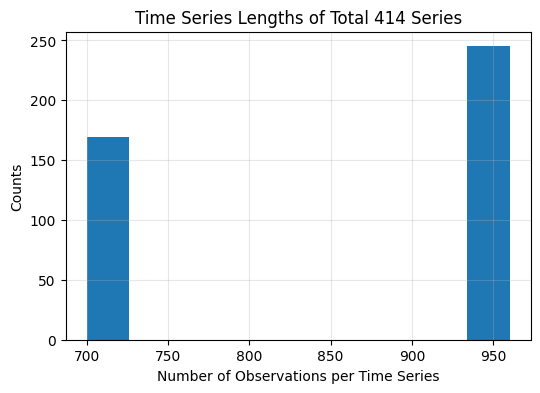

In [4]:
import matplotlib.pyplot as plt

# Count number of unique time series and number of observations per item_id
n_unique_series = context_df['item_id'].nunique()
lengths = context_df.groupby('item_id')['timestamp'].count()

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.hist(lengths)
plt.title(f'Time Series Lengths of Total {n_unique_series} Series')
plt.xlabel('Number of Observations per Time Series')
plt.ylabel('Counts')
plt.grid(alpha=0.3)
plt.show()

In [5]:
pred_df = pipeline.predict_df(context_df, id_column="item_id", target="target", timestamp_column="timestamp", 
                              prediction_length=24, quantile_levels=[0.1, 0.9])
pred_df

/home/fli/.local/miniforge3/envs/python3.12-forecasting/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,item_id,timestamp,target_name,predictions,0.1,0.9
0,H1,1750-01-30 04:00:00,target,624.867920,611.385071,638.598755
1,H1,1750-01-30 05:00:00,target,563.703125,546.655029,578.665649
2,H1,1750-01-30 06:00:00,target,521.589966,505.747437,537.950806
3,H1,1750-01-30 07:00:00,target,489.910706,473.671875,508.854126
4,H1,1750-01-30 08:00:00,target,471.144501,452.199432,491.050385
...,...,...,...,...,...,...
9931,H414,1750-02-10 19:00:00,target,61.697697,49.787407,75.447968
9932,H414,1750-02-10 20:00:00,target,52.210613,41.923550,65.115601
9933,H414,1750-02-10 21:00:00,target,46.259838,36.681187,55.795204
9934,H414,1750-02-10 22:00:00,target,33.599995,26.682121,41.483685


## Retail Demand Forecasting

Forecast next quarter's weekly store sales using historical sales, historical customer footfall (Customers), and known covariates indicating store operation (Open), promotion periods (Promo), and holidays (SchoolHoliday, StateHoliday).

In [6]:
import matplotlib.pyplot as plt
# Visualization helper function
def plot_forecast(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str = "id",
    timestamp_column: str = "timestamp",
    history_length: int = 256,
    title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id and target_name == @target_column").set_index(
        timestamp_column
    )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    print(start_idx)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    fig.show()

In [7]:
# Retail forecasting configuration
target = "Sales"  # Column name containing sales values to forecast
prediction_length = 13  # Number of days to forecast ahead
id_column = "id"  # Column identifying different products/stores
timestamp_column = "timestamp"  # Column containing datetime information
timeseries_id = "1"  # Specific time series to visualize (product/store ID)

# Load historical sales and past values of covariates
sales_context_df = pd.read_parquet("../data/retail_sales_train.parquet")
sales_context_df

,id,timestamp,Sales,Open,Promo,SchoolHoliday,StateHoliday,Customers
0,1,2013-01-13,32952.0,0.857143,0.714286,5.0,0.0,3918.0
1,1,2013-01-20,25978.0,0.857143,0.000000,0.0,0.0,3417.0
2,1,2013-01-27,33071.0,0.857143,0.714286,0.0,0.0,3862.0
3,1,2013-02-03,28693.0,0.857143,0.000000,0.0,0.0,3561.0
4,1,2013-02-10,35771.0,0.857143,0.714286,0.0,0.0,4094.0
...,...,...,...,...,...,...,...,...
133795,999,2015-03-29,43358.0,0.857143,0.000000,0.0,0.0,3252.0
133796,999,2015-04-05,69663.0,0.714286,0.714286,2.0,1.0,4424.0
133797,999,2015-04-12,35267.0,0.714286,0.000000,5.0,1.0,2771.0
133798,999,2015-04-19,63849.0,0.857143,0.714286,0.0,0.0,4230.0


In [8]:
# Load future values of covariates
sales_test_df = pd.read_parquet("../data/retail_sales_test.parquet")
sales_future_df = sales_test_df.drop(columns=target)
sales_future_df

,id,timestamp,Open,Promo,SchoolHoliday,StateHoliday
0,1,2015-05-03,0.714286,0.714286,0.0,1.0
1,1,2015-05-10,0.857143,0.714286,0.0,0.0
2,1,2015-05-17,0.714286,0.000000,0.0,1.0
3,1,2015-05-24,0.857143,0.714286,0.0,0.0
4,1,2015-05-31,0.714286,0.000000,0.0,1.0
...,...,...,...,...,...,...
14490,999,2015-06-28,0.857143,0.000000,0.0,0.0
14491,999,2015-07-05,0.857143,0.714286,0.0,0.0
14492,999,2015-07-12,0.857143,0.000000,0.0,0.0
14493,999,2015-07-19,0.857143,0.714286,5.0,0.0


In [9]:
# forecast without covariates
sales_pred_no_cov_df = pipeline.predict_df(
    sales_context_df[[id_column, timestamp_column, target]],
    future_df=None,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)
sales_pred_no_cov_df

/home/fli/.local/miniforge3/envs/python3.12-forecasting/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,id,timestamp,target_name,predictions,0.1,0.5,0.9
0,1,2015-05-03,Sales,28868.748047,24831.212891,28868.748047,32377.041016
1,1,2015-05-10,Sales,23496.941406,20528.726562,23496.941406,28279.544922
2,1,2015-05-17,Sales,28338.820312,23889.726562,28338.820312,32065.578125
3,1,2015-05-24,Sales,24089.552734,20643.382812,24089.552734,29365.500000
4,1,2015-05-31,Sales,27662.677734,22583.529297,27662.677734,31700.175781
...,...,...,...,...,...,...,...
14490,999,2015-06-28,Sales,53684.523438,38193.707031,53684.523438,66396.882812
14491,999,2015-07-05,Sales,56915.792969,38879.421875,56915.792969,66857.281250
14492,999,2015-07-12,Sales,53435.718750,37711.117188,53435.718750,66004.093750
14493,999,2015-07-19,Sales,56994.828125,38699.750000,56994.828125,66507.718750


In [10]:
# Generate predictions with covariates
sales_pred_df = pipeline.predict_df(
    sales_context_df,
    future_df=sales_future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)
sales_pred_df

/home/fli/.local/miniforge3/envs/python3.12-forecasting/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,id,timestamp,target_name,predictions,0.1,0.5,0.9
0,1,2015-05-03,Sales,28939.392578,25214.275391,28939.392578,32411.093750
1,1,2015-05-10,Sales,25541.919922,21921.328125,25541.919922,29191.931641
2,1,2015-05-17,Sales,23640.238281,20500.337891,23640.238281,26884.664062
3,1,2015-05-24,Sales,26778.261719,23318.355469,26778.261719,30162.820312
4,1,2015-05-31,Sales,22679.357422,19722.279297,22679.357422,25990.039062
...,...,...,...,...,...,...,...
14490,999,2015-06-28,Sales,40080.480469,34807.414062,40080.480469,47214.664062
14491,999,2015-07-05,Sales,68556.195312,61109.792969,68556.195312,75537.328125
14492,999,2015-07-12,Sales,40855.218750,35225.351562,40855.218750,48365.937500
14493,999,2015-07-19,Sales,66134.984375,59100.578125,66134.984375,73635.484375


0


/tmp/ipykernel_312479/29794273.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


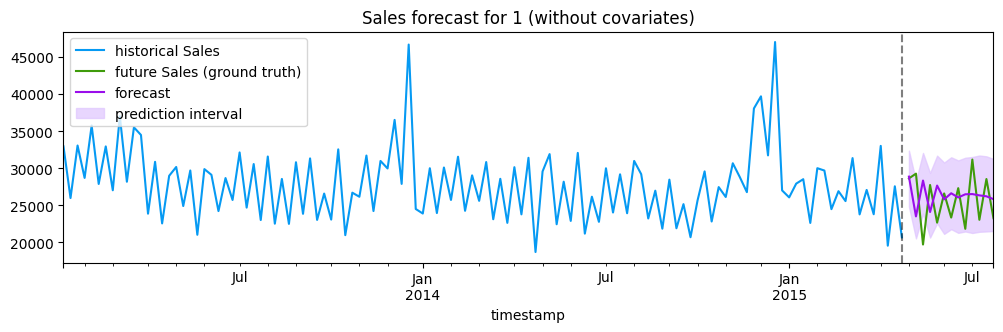

In [11]:
plot_forecast(
    sales_context_df,
    sales_pred_no_cov_df,
    sales_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(without covariates)",
)

0


/tmp/ipykernel_312479/29794273.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


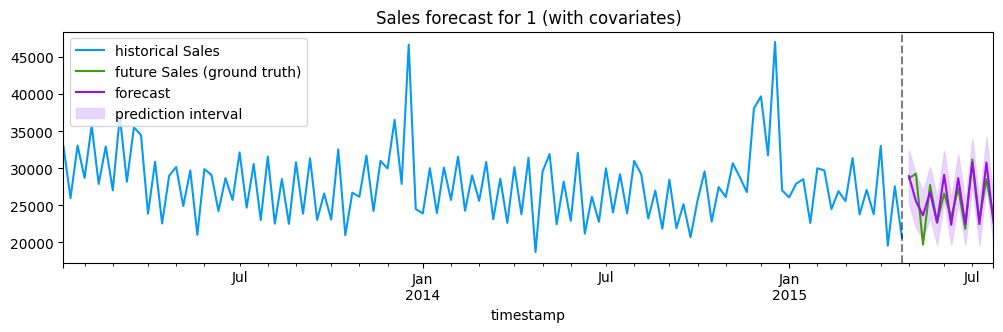

In [12]:
# Visualize forecast with covariates
plot_forecast(
    sales_context_df,
    sales_pred_df,
    sales_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(with covariates)",
)